# In this project, I work with a US Health Insurance dataset training and fine-tuning a model to predict healthcare premiums.

### Link to dataset (https://www.kaggle.com/teertha/ushealthinsurancedataset)

In [100]:
import pandas as pd
import numpy as np

In [101]:
insurance = pd.read_csv("/Users/lucasmendicino/desktop/insurance.csv")

In [102]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [103]:
# new variable: pregancies -- # of pregnancies

females = insurance[insurance['sex'] == 'female']
insurance['pregnancies'] = females['children']
insurance['pregnancies'] = insurance['pregnancies'].replace(np.nan,0)
insurance.describe()

,age,bmi,children,charges,pregnancies
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000
mean,39.207025,30.663397,1.094918,13270.422265,0.53139
std,14.049960,6.098187,1.205493,12110.011237,0.99557
min,18.000000,15.960000,0.000000,1121.873900,0.00000
25%,27.000000,26.296250,0.000000,4740.287150,0.00000
50%,39.000000,30.400000,1.000000,9382.033000,0.00000
75%,51.000000,34.693750,2.000000,16639.912515,1.00000
max,64.000000,53.130000,5.000000,63770.428010,5.00000


In [104]:
# convert to category

for x in ['sex', 'children', 'smoker', 'region', 'pregnancies']:
    insurance[x] = insurance[x].astype('category')
    
insurance.dtypes

age               int64
sex            category
bmi             float64
children       category
smoker         category
region         category
charges         float64
pregnancies    category
dtype: object

In [105]:
# select all columns of the dataFrame with datatype = category:

categories = insurance.select_dtypes(['category']).columns
categories

Index(['sex', 'children', 'smoker', 'region', 'pregnancies'], dtype='object')

In [106]:
# transform the original columns by replacing the elements with their category codes:

insurance[categories] = insurance[categories].apply(lambda x: x.cat.codes)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,pregnancies
0,19,0,27.900,0,1,3,16884.92400,0
1,18,1,33.770,1,0,2,1725.55230,0
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,0


# Correlation

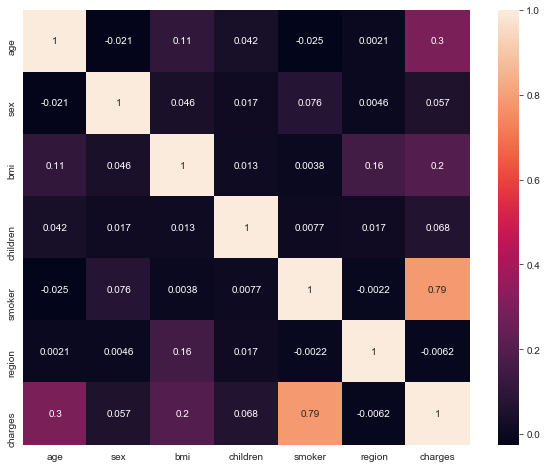

In [48]:
corr = insurance.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, annot = True)
plt.show()

# Let's prepare out train and test sets and create a pipeline to preprocess the data.

In [107]:
# create train and test sets
from sklearn.model_selection import train_test_split

X = insurance[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'pregnancies']]
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [108]:
# Let's create a pipeline to deal with preprocessing of the data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

features_num = ['age', 'bmi']
features_cat = ['sex', 'children', 'smoker', 'region', 'pregnancies']

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('Features numerical', num_transformer, features_num),
        ('Features categorical', cat_transformer, features_cat)
    ])

# First, let's do a regularized form of Linear Regression, Lasso Regression. It uses an L1 penalty term that can allow us to figure out feature importances.

In [128]:
from sklearn.linear_model import Lasso

lasso_reg = Pipeline([('preprocessor', preprocessor),
                  ('classifier', Lasso(alpha = 0.1))
                 ])

lasso_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Features numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('Features categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'children', 'smoker',
                                                   'region',
                                                   'pregnancies'])])),
                ('classifier', Lasso(alpha=0.1))])

In [129]:
from sklearn.model_selection import GridSearchCV

param_distrib = {'classifier__alpha': np.arange(0.1,10,0.1)}

gd = GridSearchCV(lasso_reg, param_distrib, cv = 5, scoring = "neg_mean_squared_error" )

gd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('Features '
                                                                         'numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('Features '
                                                                         'categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())

In [130]:
coefficients = gd.best_estimator_.named_steps['classifier'].coef_
importance = np.abs(coefficients)
importance

array([3.61628327e+03, 2.00952432e+03, 1.48654562e+02, 0.00000000e+00,
       6.41461386e+02, 6.26834418e+02, 8.60076595e+02, 0.00000000e+00,
       1.18689697e+03, 0.00000000e+00, 2.35911472e+04, 0.00000000e+00,
       5.68744952e+02, 1.69767733e+02, 6.16620319e+00, 1.61037968e+02,
       0.00000000e+00, 6.90938606e+02, 2.82880223e+01, 0.00000000e+00,
       2.33077363e+03, 0.00000000e+00])

In [131]:
features_num = ['age', 'bmi']
features_cat = ['sex', 'children', 'smoker', 'region', 'pregnancies']

attributes = features_num + features_cat 
sorted(zip(importance, attributes), reverse = True)

[(3616.283268582154, 'age'),
 (2009.5243156219858, 'bmi'),
 (860.0765948286261, 'pregnancies'),
 (641.4613857144955, 'smoker'),
 (626.8344175588987, 'region'),
 (148.6545620971342, 'sex'),
 (0.0, 'children')]

# Let's remove children from our features list

In [139]:
X = insurance[['age', 'sex', 'bmi', 'smoker', 'region', 'pregnancies']]
y = insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


features_cat = ['sex', 'smoker', 'region', 'pregnancies']

preprocessor = ColumnTransformer(
    transformers=[
        ('Features numerical', num_transformer, features_num),
        ('Features categorical', cat_transformer, features_cat)
    ])

# Let's do some modeling with Linear Regression

In [140]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([('preprocessor', preprocessor),
                  ('classifier', LinearRegression())
                 ])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Features numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('Features categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region',
                                                   'pregnancies'])])),
                ('classifier', LinearRegression())])

In [141]:
from sklearn.metrics import mean_squared_error

lr_preds = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, lr_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6099.101799108426

In [142]:
from sklearn.model_selection import cross_val_score

lr_cv = cross_val_score(lin_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv = 10)
lr_rmse_scores = np.sqrt(-lr_cv)

In [143]:
def display_scores(cv):
    print("Scores:", cv)
    print("Mean:", cv.mean())
    print("Standard deviation:", cv.std())

display_scores(lr_rmse_scores)

Scores: [6137.11928234 6536.15246418 5241.65541183 6096.05978554 5836.27139425
 6231.58397905 7287.19570028 6228.64971007 6212.70856062 5739.29851475]
Mean: 6154.669480290018
Standard deviation: 505.3860435850475


## Let's try a Decision Tree Regressor

In [144]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([('preprocessor', preprocessor),
                 ('classifier', DecisionTreeRegressor(random_state = 42))
                 ])

tree_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Features numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('Features categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region',
                                                   'pregnancies'])])),
                ('classifier', DecisionTreeRegressor(random_state=42))])

In [145]:
tree_preds = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

494.53390138188126

In [146]:
tree_cv = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_cv)

In [147]:
display_scores(tree_rmse_scores)

Scores: [5492.9084016  6540.20582807 5504.70419003 7219.36870689 6672.42946254
 7509.35421674 7645.32592737 6686.321583   7362.13868226 5547.74631049]
Mean: 6618.050330898312
Standard deviation: 801.8529502952574


# Let's try a Random Forest Regressor

In [148]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([('preprocessor', preprocessor),
                 ('classifier', RandomForestRegressor(n_estimators = 10, random_state = 42))
                 ])

forest_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Features numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('Features categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region',
                                                   'pregnancies'])])),
                ('classifier',
                 RandomForestRegressor(n_estimators=10, random_state=42))])

In [149]:
forest_preds = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_preds)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2281.7191747710626

In [150]:
forest_cv = cross_val_score(forest_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_cv)
display_scores(forest_rmse_scores)

Scores: [4672.61630949 5385.22742952 4467.7752236  4546.34199815 5180.57797975
 4913.96335488 5837.43498489 5297.40354715 5659.45971771 5084.12547403]
Mean: 5104.492601917644
Standard deviation: 436.713081952747


In [151]:
pd.Series(np.sqrt(-forest_cv)).describe()

count      10.000000
mean     5104.492602
std       460.336008
min      4467.775224
25%      4732.953071
50%      5132.351727
75%      5363.271459
max      5837.434985
dtype: float64

# Let's try a Support Vector Machine

In [152]:
from sklearn.svm import SVR

svm_reg = Pipeline([('preprocessor', preprocessor),
                   ('classifierr', SVR(kernel = 'linear'))
                   ])

svm_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Features numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi']),
                                                 ('Features categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region',
                                                   'pregnancies'])])),
                ('classifierr', SVR(kernel='linear'))])

In [153]:
svm_preds = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, svm_preds)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

12408.125710092547

In [154]:
svm_cv = cross_val_score(svm_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_cv)
display_scores(svm_rmse_scores)

Scores: [12424.76037614 12343.08548368 12613.18252778 14412.830259
 12806.24018933 10281.12599002 12230.75485633 12031.98921436
 12752.02715127 12059.82646333]
Mean: 12395.582251124242
Standard deviation: 957.0248055244615


In [155]:
result_data = {'Linear Regression': (lr_rmse_scores.mean().round(2), lr_rmse_scores.std().round(2)), 
               'Decision Tree Regressor': (tree_rmse_scores.mean().round(2), tree_rmse_scores.std().round(2)), 
               'Random Forest Regressor': (forest_rmse_scores.mean().round(2), forest_rmse_scores.std().round(2)), 
               'Support Vector Machine':  (svm_rmse_scores.mean().round(2), svm_rmse_scores.std().round(2))}


#result_data = {'Model Name': [Linear Regression, Decision Tree Regressor, Random Forest Regressor, 
#                              Support Vector Machine],
 #             'Mean 10-fold CV RMSE': [lr_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean(),
  #                                    svm_rmse_scores.mean()]}

result_df = pd.DataFrame(list(result_data.items()), columns = ['Model', 'Mean 10-fold CV RMSE, SD'])
result_df

,Model,"Mean 10-fold CV RMSE, SD"
0,Linear Regression,"(6154.67, 505.39)"
1,Decision Tree Regressor,"(6618.05, 801.85)"
2,Random Forest Regressor,"(5104.49, 436.71)"
3,Support Vector Machine,"(12395.58, 957.02)"


# Let's tune the parameters of our Random Forest Regressor

In [156]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low = 1, high = 800),
        'max_features': randint(low = 1, high = 10),
    }

forest_reg = RandomForestRegressor(random_state = 42)

rnd_search = RandomizedSearchCV(forest_reg, param_distributions = param_distribs,
                               n_iter = 50, cv = 10, scoring = "neg_mean_squared_error", random_state = 42)

X_train_prepd = preprocessor.fit_transform(X_train)

rnd_search.fit(X_train_prepd, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff85ac80610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff85ac803d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [157]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4813.587073649978 {'max_features': 7, 'n_estimators': 436}
4826.913023204107 {'max_features': 8, 'n_estimators': 701}
4806.591559615142 {'max_features': 5, 'n_estimators': 615}
4913.836475717504 {'max_features': 3, 'n_estimators': 215}
4826.16936566951 {'max_features': 8, 'n_estimators': 373}
4840.639598141108 {'max_features': 4, 'n_estimators': 664}
4915.53434375258 {'max_features': 3, 'n_estimators': 662}
4807.32614250094 {'max_features': 5, 'n_estimators': 770}
4826.989623733006 {'max_features': 8, 'n_estimators': 492}
4806.870655535346 {'max_features': 6, 'n_estimators': 386}
4826.181839327812 {'max_features': 5, 'n_estimators': 161}
4804.3460231675335 {'max_features': 6, 'n_estimators': 253}
4844.796426886323 {'max_features': 9, 'n_estimators': 561}
4909.320622070942 {'max_features': 3, 'n_estimators': 567}
4847.041579664879 {'max_features': 4, 'n_estimators': 505}
4903.5491599650395 {'max_features': 3, 'n_estimators': 485}
4914.333769322828 {'max_features': 3, 'n_estimators': 647

In [158]:
neg_mse = rnd_search.best_score_
rmse = np.sqrt(-neg_mse)
rmse

4804.3460231675335

In [159]:
rnd_search.best_params_

{'max_features': 6, 'n_estimators': 253}

In [160]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([1.47984493e-01, 1.80567735e-01, 4.03938985e-03, 3.75190146e-03,
       3.19294830e-01, 3.03233413e-01, 6.82721496e-03, 5.57998714e-03,
       6.66761557e-03, 4.58381081e-03, 4.56768698e-03, 4.15583685e-03,
       3.41476109e-03, 2.16174526e-03, 2.91432547e-03, 2.55252728e-04])

In [161]:
features_num = ['age', 'bmi']
features_cat = ['sex', 'smoker', 'region', 'pregnancies']

attributes = features_num + features_cat 
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3192948300547223, 'region'),
 (0.3032334133269448, 'pregnancies'),
 (0.18056773518694044, 'bmi'),
 (0.14798449325750693, 'age'),
 (0.004039389851603868, 'sex'),
 (0.0037519014628370605, 'smoker')]

In [162]:
X_test_prepd = preprocessor.fit_transform(X_test)

final_model = rnd_search.best_estimator_

final_pred = final_model.predict(X_test_prepd)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

4690.865543690981

In [163]:
from scipy import stats

confidence = 0.95
squared_errors = (final_pred - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc = np.mean(squared_errors),
                         scale = stats.sem(squared_errors)))

array([3723.52230937, 5490.33885199])

In [164]:
some_data = X_train_prepd[4:8]
some_labels = y_train[4:8]

print(X_train[4:8])
print("Predictions:\t", final_model.predict(some_data))
print("Labels:\t\t", list(some_labels))

      age  sex     bmi  smoker  region  pregnancies
486    54    0  21.470       0       1            3
170    63    1  41.470       0       2            0
277    22    0  24.300       0       3            0
1033   18    1  21.565       1       0            0
Predictions:	 [12322.71040648 13654.95776759  2282.12524644 14275.22472403]
Labels:		 [12475.3513, 13405.3903, 2150.469, 13747.87235]
